In [1]:
import sys
sys.path.append("../")

import torch
import numpy as np
import math
import pickle
import torch.nn as nn
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj, erdos_renyi_graph
from models.GRDPG_GD_Unroll_unshared_normalized import gLASE
from models.rsvd import rsvd
from models.RDPG_GD import GRDPG_GD_Armijo

import matplotlib.pyplot as plt
import seaborn as sns

# Subgraph SBM-2 negative eigenvalues 

Loss GLASE unshared weights (5 layers):  tensor(5171.7695)


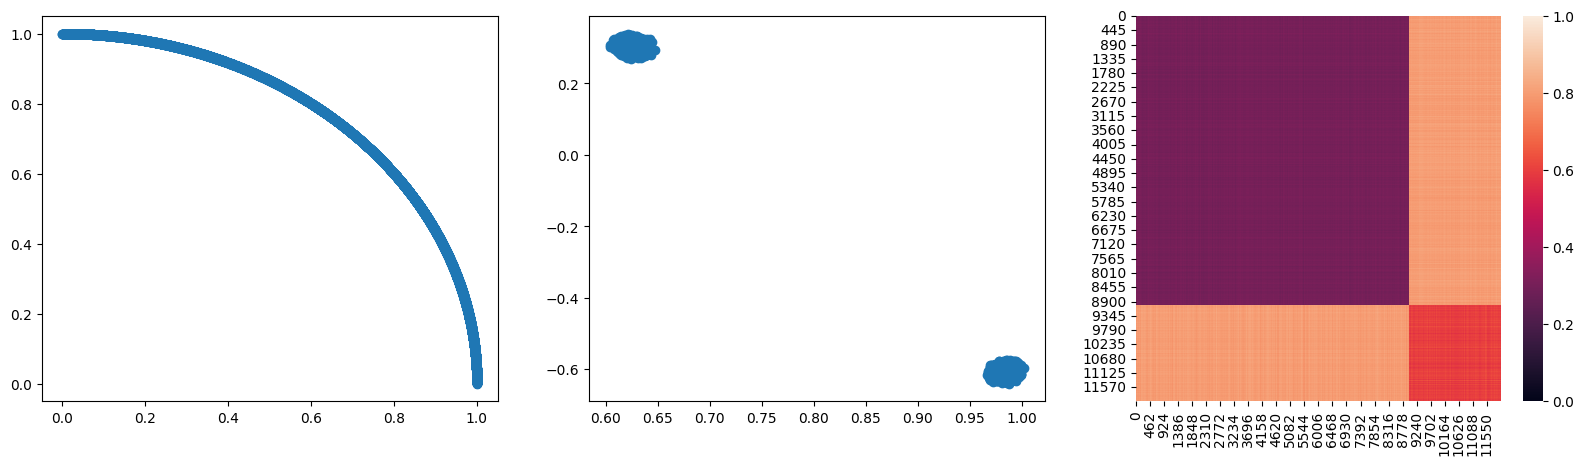

In [3]:
# Load model

d = 2
gd_steps = 5
device = 'cpu'

model = gLASE(d,d, gd_steps)
model.load_state_dict(torch.load('../saved_models/glase_unshared_d2_normalized_full_negative_phase2_subgraphs_095_unbalanced_complete.pt'))
model.to(device)


# Load original graph

ORIGINAL_GRAPH = '../training/data/sbm2_original_graph_negative_095_unbalanced.pkl'
with open(ORIGINAL_GRAPH, 'rb') as f:
    data= pickle.load(f)

num_nodes = data.num_nodes
edge_index = data.edge_index
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
q = torch.cat((torch.ones(d // 2), -torch.ones(d // 2)))  ## Hay que cambiar por un load
Q = torch.diag(q).detach()

def get_x_init(num_nodes, alpha, beta):
    angles = torch.linspace(alpha, beta, num_nodes)
    x = torch.stack((torch.cos(angles), torch.sin(angles)), dim=1)
    return x

x = get_x_init(num_nodes, 0, math.pi/2 ).to(device) 
x_glase = model(x, edge_index, edge_index_2, Q, mask)
x_glase = x_glase.detach()
loss = torch.norm((x_glase@Q@x_glase.T - to_dense_adj(edge_index).squeeze(0)))
print(f"Loss GLASE unshared weights ({gd_steps} layers): ", loss)
x_lase = x_glase.to('cpu')

fig, axes = plt.subplots(1, 3, figsize =(20,5))
axes[0].scatter(x[:,0],x[:,1] )
axes[1].scatter(x_glase[:,0],x_glase[:,1] )
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[2], vmin=0.0, vmax=1.0, cbar=True)
plt.show()


# Subgraph SBM-2 positive eigenvalues 

Loss GLASE unshared weights (5 layers):  tensor(4037.4006)


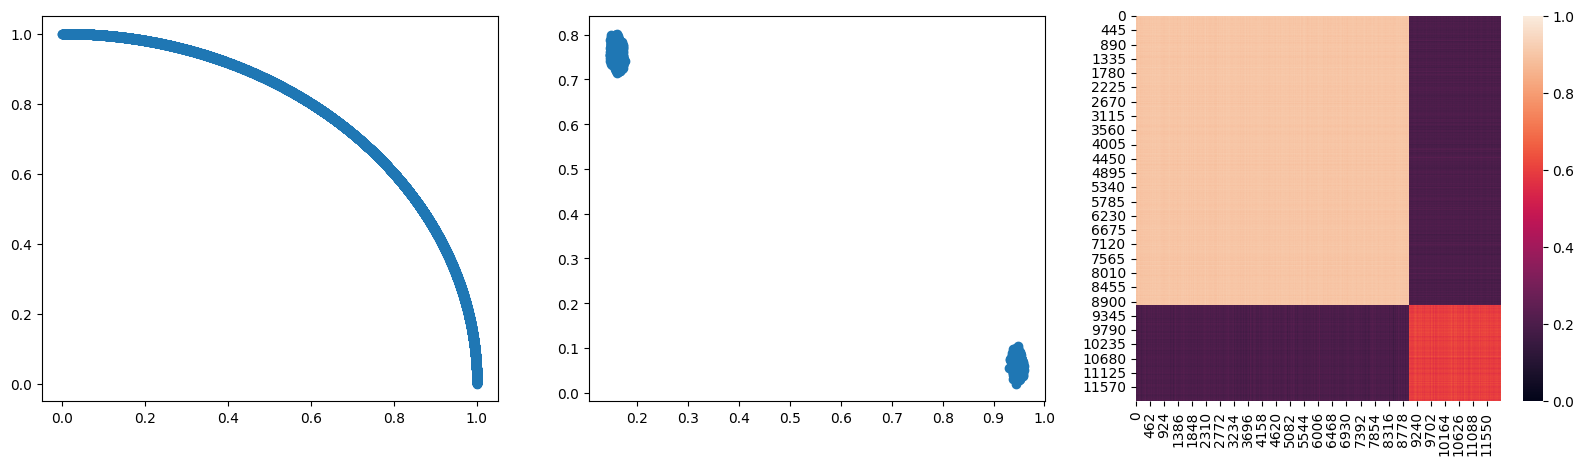

In [2]:
# Load model

d = 2
gd_steps = 5
device = 'cpu'

model = gLASE(d,d, gd_steps)
model.load_state_dict(torch.load('../saved_models/glase_unshared_d2_normalized_full_positive_subgraphs_095_unbalanced_complete.pt'))
model.to(device)


# Load original graph

ORIGINAL_GRAPH = '../training/data/sbm2_original_graph_positive_095_unbalanced.pkl'
with open(ORIGINAL_GRAPH, 'rb') as f:
    data= pickle.load(f)

num_nodes = data.num_nodes
edge_index = data.edge_index
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
q = torch.cat((torch.ones(d // 2), torch.ones(d // 2)))  ## Hay que cambiar por un load
Q = torch.diag(q).detach()

def get_x_init(num_nodes, alpha, beta):
    angles = torch.linspace(alpha, beta, num_nodes)
    x = torch.stack((torch.cos(angles), torch.sin(angles)), dim=1)
    return x

x = get_x_init(num_nodes, 0, math.pi/2 ).to(device) 
x_glase = model(x, edge_index, edge_index_2, Q, mask)
x_glase = x_glase.detach()
loss = torch.norm((x_glase@Q@x_glase.T - to_dense_adj(edge_index).squeeze(0)))
print(f"Loss GLASE unshared weights ({gd_steps} layers): ", loss)
x_lase = x_glase.to('cpu')

fig, axes = plt.subplots(1, 3, figsize =(20,5))
axes[0].scatter(x[:,0],x[:,1] )
axes[1].scatter(x_glase[:,0],x_glase[:,1] )
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[2], vmin=0.0, vmax=1.0, cbar=True)
plt.show()


In [4]:
p = [
     [0.6, 0.9, 0.8],
     [0.9, 0.3, 0.7],
     [0.8, 0.7, 0.5]
]

p_arr = np.array(p)
np.linalg.eig(p_arr)


(array([ 2.07826069, -0.46325476, -0.21500593]),
 array([[-0.63044619, -0.62341611, -0.46248238],
        [-0.53897073,  0.78033365, -0.31715917],
        [-0.5586127 , -0.04931267,  0.82796142]]))

In [6]:
loss1=3
loss2=2
loss3=5

arr_loss = np.array([loss1, loss2, loss3])

np.argmin(arr_loss)

1